# Inverse Kinematics for a Planar Two-Link Robotic Arm

A classic problem with robotic arms is getting the end-effector, the mechanism at the end of the arm responsible for manipulating the environment, to where you need it to be. Maybe the end-effector is a gripper and maybe you want to pick up an object and maybe you know where that object is relative to the robot - but you cannot tell the end-effector where to go directly. Instead, you have to determine the joint angles that get the end-effector to where you want it to be. This problem is known as inverse kinematics.

Credit for this solution goes to: https://robotacademy.net.au/lesson/inverse-kinematics-for-a-2-joint-robot-arm-using-geometry/

First, let's define a class to make plotting our arm easier.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

class TwoLinkArm:
    def __init__(self, joint_angles=[0, 0]):
        self.shoulder = np.array([0, 0])
        self.link_lengths = [1, 1]
        self.update_joints(joint_angles)
        
    def update_joints(self, joint_angles):
        self.joint_angles = joint_angles
        self.forward_kinematics()
        
    def forward_kinematics(self):
        theta0 = self.joint_angles[0]
        theta1 = self.joint_angles[1]
        l0 = self.link_lengths[0]
        l1 = self.link_lengths[1]
        self.elbow = self.shoulder + np.array([l0*np.cos(theta0), l0*np.sin(theta0)])
        self.wrist = self.elbow + np.array([l1*np.cos(theta0 + theta1), l1*np.sin(theta0 + theta1)])
        
    def plot(self):
        plt.plot([self.shoulder[0], self.elbow[0]],
                 [self.shoulder[1], self.elbow[1]],
                 'r-')
        plt.plot([self.elbow[0], self.wrist[0]],
                 [self.elbow[1], self.wrist[1]],
                 'r-')
        plt.plot(self.shoulder[0], self.shoulder[1], 'ko')
        plt.plot(self.elbow[0], self.elbow[1], 'ko')
        plt.plot(self.wrist[0], self.wrist[1], 'ko')

Let's also define a function to make it easier to draw an angle on our diagram.

In [2]:
def transform_points(points, theta, origin):
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    T = np.array([[cos_theta, -sin_theta, origin[0]],
                  [sin_theta, cos_theta, origin[1]],
                  [0, 0, 1]])
    return np.matmul(T, np.array(points))

def draw_angle(angle, offset=0, origin=[0, 0], r=0.5, n_points=100):
        x_start = r*np.cos(angle)
        x_end = r
        dx = (x_end - x_start)/(n_points-1)
        coords = [[0 for _ in range(n_points)] for _ in range(3)]
        x = x_start
        for i in range(n_points-1):
            y = np.sqrt(r**2 - x**2)
            coords[0][i] = x
            coords[1][i] = y
            coords[2][i] = 1
            x += dx
        coords[0][-1] = r
        coords[2][-1] = 1
        coords = transform_points(coords, offset, origin)
        plt.plot(coords[0], coords[1], 'k-')

Okay, we now have a TwoLinkArm class to help us draw the arm, which we'll do several times during our derivation. Notice there is a method called <i>forward_kinematics</i> - forward kinematics specifies the end-effector position <i>given</i> the joint angles and link lengths. Forward kinematics is easier than inverse kinematics.

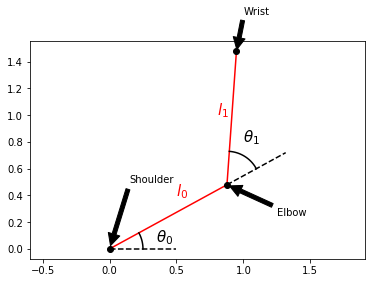

In [3]:
arm = TwoLinkArm()

theta0 = 0.5
theta1 = 1

arm.update_joints([theta0, theta1])
arm.plot()

def label_diagram():
    plt.plot([0, 0.5], [0, 0], 'k--')
    plt.plot([arm.elbow[0], arm.elbow[0]+0.5*np.cos(theta0)],
             [arm.elbow[1], arm.elbow[1]+0.5*np.sin(theta0)],
             'k--')
    
    draw_angle(theta0, r=0.25)
    draw_angle(theta1, offset=theta0, origin=[arm.elbow[0], arm.elbow[1]], r=0.25)
    
    plt.annotate("$l_0$", xy=(0.5, 0.4), size=15, color="r")
    plt.annotate("$l_1$", xy=(0.8, 1), size=15, color="r")
    
    plt.annotate(r"$\theta_0$", xy=(0.35, 0.05), size=15)
    plt.annotate(r"$\theta_1$", xy=(1, 0.8), size=15)

label_diagram()

plt.annotate("Shoulder", xy=(arm.shoulder[0], arm.shoulder[1]), xytext=(0.15, 0.5),
    arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("Elbow", xy=(arm.elbow[0], arm.elbow[1]), xytext=(1.25, 0.25),
    arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("Wrist", xy=(arm.wrist[0], arm.wrist[1]), xytext=(1, 1.75),
    arrowprops=dict(facecolor='black', shrink=0.05))

plt.axis("equal")

plt.show()

It's common to name arm joints anatomically, hence the names <i>shoulder</i>, <i>elbow</i>, and <i>wrist</i>. In this example, the wrist is not itself a joint, but we can consider it to be our end-effector. If we constrain the shoulder to the origin, we can write the forward kinematics for the elbow and the wrist.

$elbow_x = l_0\cos(\theta_0)$    
$elbow_y = l_0\sin(\theta_0)$  

$wrist_x = elbow_x + l_1\cos(\theta_0+\theta_1) = l_0\cos(\theta_0) + l_1\cos(\theta_0+\theta_1)$  
$wrist_y = elbow_y + l_1\sin(\theta_0+\theta_1) = l_0\sin(\theta_0) + l_1\sin(\theta_0+\theta_1)$  

Since the wrist is our end-effector, let's just call its coordinates <i>$x$</i> and <i>$y$</i>. The forward kinematics for our end-effector is then

$x = l_0\cos(\theta_0) + l_1\cos(\theta_0+\theta_1)$   
$y = l_0\sin(\theta_0) + l_1\sin(\theta_0+\theta_1)$ 

A first attempt to find the joint angles $\theta_0$ and $\theta_1$ that would get our end-effector to the desired coordinates $x$ and $y$ might be to try solving the forward kinematics for $\theta_0$ and $\theta_1$, but that would be the wrong move. An easier path involves going back to the geometry of the arm.

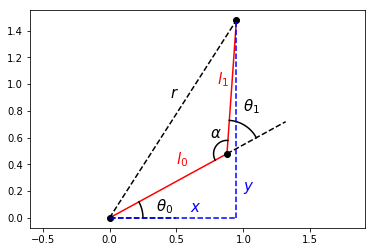

In [4]:
from math import pi

arm.plot()
label_diagram()

plt.plot([0, arm.wrist[0]],
         [0, arm.wrist[1]],
         'k--')

plt.plot([arm.wrist[0], arm.wrist[0]],
         [0, arm.wrist[1]],
         'b--')
plt.plot([0, arm.wrist[0]],
         [0, 0],
         'b--')

plt.annotate("$x$", xy=(0.6, 0.05), size=15, color="b")
plt.annotate("$y$", xy=(1, 0.2), size=15, color="b")
plt.annotate("$r$", xy=(0.45, 0.9), size=15)
plt.annotate(r"$\alpha$", xy=(0.75, 0.6), size=15)

alpha = pi-theta1
draw_angle(alpha, offset=theta0+theta1, origin=[arm.elbow[0], arm.elbow[1]], r=0.1)

plt.axis("equal")
plt.show()

The distance from the end-effector to the robot base (shoulder joint) is $r$ and can be written in terms of the end-effector position using the Pythagorean Theorem.

$r^2$ = $x^2 + y^2$

Then, by the law of cosines, $r$<sup>2</sup> can also be written as:

$r^2$ = $l_0^2 + l_1^2 - 2l_0l_1\cos(\alpha)$

Because $\alpha$ can be written as $\pi - \theta_1$, we can relate the desired end-effector position to one of our joint angles, $\theta_1$.

$x^2 + y^2$ = $l_0^2 + l_1^2 - 2l_0l_1\cos(\alpha)$  
  
$x^2 + y^2$ = $l_0^2 + l_1^2 - 2l_0l_1\cos(\pi-\theta_1)$  
  
$2l_0l_1\cos(\pi-\theta_1) = l_0^2 + l_1^2 - x^2 - y^2$  
  
$\cos(\pi-\theta_1) = \frac{l_0^2 + l_1^2 - x^2 - y^2}{2l_0l_1}$  
$~$  
$~$  
$\cos(\pi-\theta_1) = -cos(\theta_1)$ is a trigonometric identity, so we can also write

$\cos(\theta_1) = \frac{x^2 + y^2 - l_0^2 - l_1^2}{2l_0l_1}$  

which leads us to an equation for $\theta_1$ in terms of the link lengths and the desired end-effector position!

$\theta_1 = \cos^{-1}(\frac{x^2 + y^2 - l_0^2 - l_1^2}{2l_0l_1})$  

This is actually one of two possible solutions for $\theta_1$, but we'll ignore the other possibility for now. This solution will lead us to the "arm-down" configuration of the arm, which is what's shown in the diagram. Now we'll derive an equation for $\theta_0$ that depends on this value of $\theta_1$.

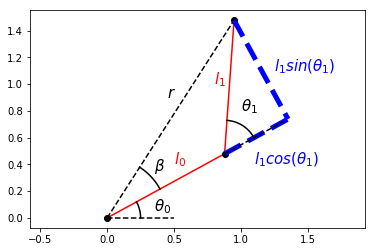

In [5]:
from math import atan2

arm.plot()
plt.plot([0, arm.wrist[0]],
         [0, arm.wrist[1]],
         'k--')

p = 1 + np.cos(theta1)
sin_theta0 = np.sin(theta0)
cos_theta0 = np.cos(theta0)
plt.plot([arm.elbow[0], p*cos_theta0],
         [arm.elbow[1], p*sin_theta0],
         'b--', linewidth=5)
plt.plot([arm.wrist[0], p*cos_theta0],
         [arm.wrist[1], p*sin_theta0],
         'b--', linewidth=5)

beta = np.arctan2(arm.wrist[1], arm.wrist[0])-theta0
draw_angle(beta, offset=theta0, r=0.45)

plt.annotate(r"$\beta$", xy=(0.35, 0.35), size=15)
plt.annotate("$r$", xy=(0.45, 0.9), size=15)
plt.annotate(r"$l_1sin(\theta_1)$",xy=(1.25, 1.1), size=15, color="b")
plt.annotate(r"$l_1cos(\theta_1)$",xy=(1.1, 0.4), size=15, color="b")

label_diagram()

plt.axis("equal")

plt.show()

Consider the angle between the displacement vector $r$ and the first link $l_0$; let's call it $\beta$. If we extend the first link to include the component of the second link in the same direction as the first, we form a right triangle with components $l_0+l_1cos(\theta_1)$ and $l_1sin(\theta_1)$, allowing us to express $\beta$ as
  
$\beta = \tan^{-1}(\frac{l_1\sin(\theta_1)}{l_0+l_1\cos(\theta_1)})$  


We now have an expression for this angle $\beta$ in terms of one of our arm's joint angles. Now, can we relate $\beta$ to $\theta_0$? Yes!

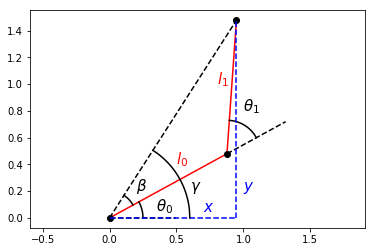

In [6]:
arm.plot()
label_diagram()
plt.plot([0, arm.wrist[0]],
         [0, arm.wrist[1]],
         'k--')

plt.plot([arm.wrist[0], arm.wrist[0]],
         [0, arm.wrist[1]],
         'b--')
plt.plot([0, arm.wrist[0]],
         [0, 0],
         'b--')

gamma = np.arctan2(arm.wrist[1], arm.wrist[0])
draw_angle(beta, offset=theta0, r=0.2)
draw_angle(gamma, r=0.6)

plt.annotate("$x$", xy=(0.7, 0.05), size=15, color="b")
plt.annotate("$y$", xy=(1, 0.2), size=15, color="b")
plt.annotate(r"$\beta$", xy=(0.2, 0.2), size=15)
plt.annotate(r"$\gamma$", xy=(0.6, 0.2), size=15)

plt.axis("equal")
plt.show()

Our first joint angle $\theta_0$ added to $\beta$ gives us the angle between the positive $x$-axis and the displacement vector $r$; let's call this angle $\gamma$.

$\gamma = \theta_0+\beta$  

$\theta_0$, our remaining joint angle, can then be expressed as 

$\theta_0 = \gamma-\beta$  

We already know $\beta$. $\gamma$ is simply the inverse tangent of $\frac{y}{x}$, so we have an equation of $\theta_0$! 

$\theta_0 = \tan^{-1}(\frac{y}{x})-\tan^{-1}(\frac{l_1\sin(\theta_1)}{l_0+l_1\cos(\theta_1)})$

We now have the inverse kinematics for a planar two-link robotic arm. If you're planning on implementing this in a programming language, it's best to use the <i>atan2</i> function, which is included in most math libraries and correctly accounts for the signs of $y$ and $x$. Notice that $\theta_1$ must be calculated before $\theta_0$.

$\theta_1 = \cos^{-1}(\frac{x^2 + y^2 - l_0^2 - l_1^2}{2l_0l_1})$  
$\theta_0 = atan2(y, x)-atan2(l_1\sin(\theta_1), l_0+l_1\cos(\theta_1))$